## Purpose:

Plot a timeseries at the pixel (2m resolution) level of the grids.

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# from pandarallel import pandarallel
import rasterio as rio
import pandas as pd
import numpy as np
import glob
import os

In [4]:
index = pd.read_pickle('../../data/rasters.pkl')
print('Loaded', len(index), 'rasters')

Loaded 378 rasters


In [5]:
grids = pd.read_pickle('../../data/grid_data.pkl')
print('Loaded', len(grids), 'grids')

Loaded 1263 grids


### Function to stack rasters into an nd-array

In [6]:
def stack_rasters(grid, max_nodata=None, date=False):
    '''
    Stacks the grid's rasters into one numpy array
    DIMENSIONS:
    0: time
    1: x
    2: y
    '''
    rasters = glob.glob('../../data/grids/' + str(grid.name) + '/*v3.0_dem.tif')  # grab all rasters
    rasters.sort(key=lambda x: x.split('_')[2])  # sort the rasters by date acquired


    arrays = []
    dates = []
    for raster in rasters:
        date = pd.to_datetime(raster.split('_')[2])
        
        dem = rio.open(raster).read(1) # Open Data        
        mask = rio.open(raster).read_masks(1).astype(float)  # Open Mask
        if dem.shape != (501,501):
            print(raster)
            return

        # Calculate Amount of No Data (100 means no data at all)
        _, counts = np.unique(mask, return_counts=True)
        mask[mask==0] = np.nan
        nodata_val = counts[0] / (counts[0] + counts[1]) * 100
        
        # Apply Laser Altimetry Correction
        raster_name = raster[raster.rfind('/')+1:raster.rfind('_')]
        dem = dem + index.loc[raster_name]['dz']
        dem = dem * mask / 255  # Mask the Data (no data becomes nan)
        
        if max_nodata:
            if nodata_val < max_nodata:
                arrays.append(dem)
                dates.append(date)
                
        else:
            arrays.append(dem)            
            dates.append(date)

    stack = np.stack(arrays, axis=0)
    if date:
        return stack, dates
    else:
        return stack

### Function to plot the rasters and pixel timeseries

In [7]:
def plot_pixel(grid, x, y):
    stack, dates = stack_rasters(grid, date=True)
    
    
    # Plot Raster Images
    fig, ax = plt.subplots(1, stack.shape[0], figsize=(20,12))
    for i in range(stack.shape[0]):
        ax[i].set_title(dates[i].strftime('%Y-%m-%d'))
        ax[i].imshow(stack[i,:,:])
        ax[i].axvline(x=x,color='red')
        ax[i].axhline(y=y,color='red')
    plt.show()

    
    # Plot Timeseries
    fig, axes = plt.subplots(1,1, figsize=(16,4))
    
    data = pd.DataFrame(stack[:,x,y], columns = ['elevation'])
    dates = pd.DataFrame(dates, columns=['date'])
    data = data.join(dates)
    axes.scatter(data['date'], data['elevation'])
    
    
    loc = mdates.MonthLocator(interval=4)
    fmt = mdates.DateFormatter('%Y-%m')
    
    axes.xaxis.set_major_locator(loc)
    axes.xaxis.set_major_formatter(fmt)
    
    for tick in axes.get_xticks():
        axes.axvline(tick, alpha=400)
    
    plt.show()

### Plot 1 Random Grid

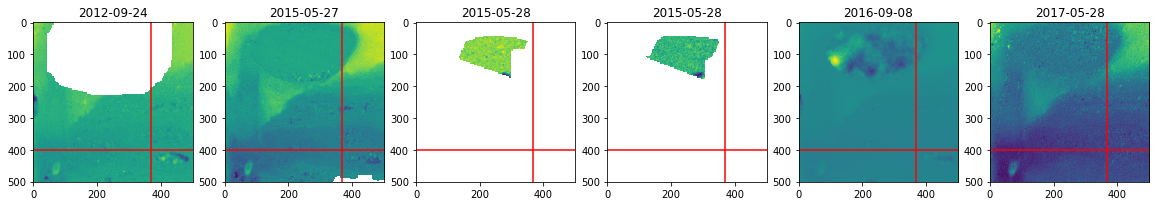

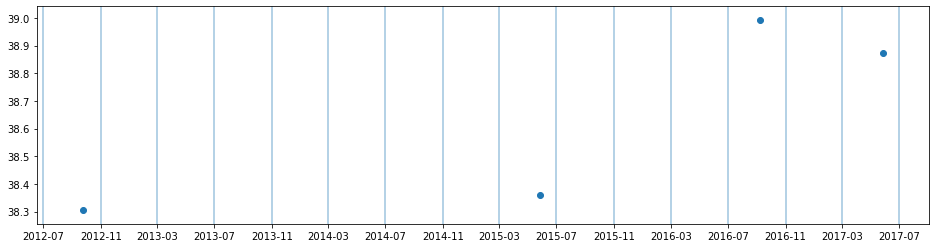

In [14]:
grid = grids.loc[np.random.choice(grids.index)]
x = np.random.randint(0,501)
y = np.random.randint(0,501)
plot_pixel(grid,x,y)

### Plot 10 Random Grids

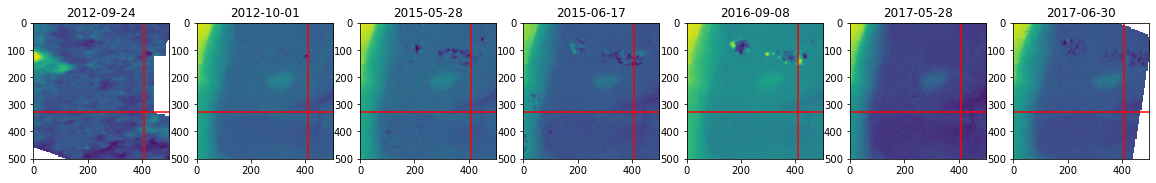

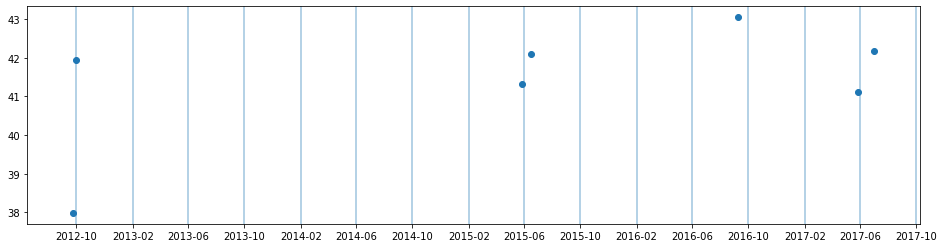

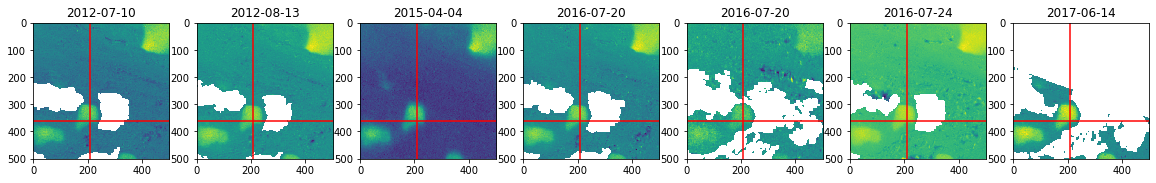

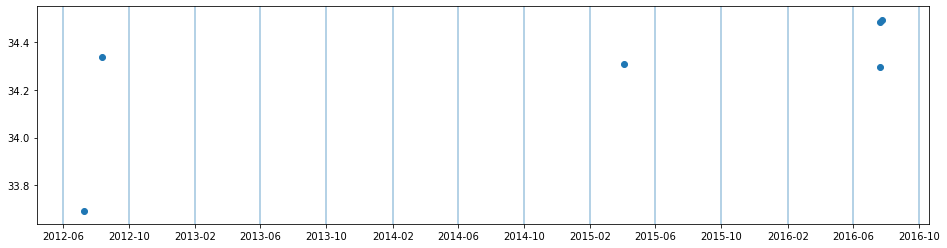

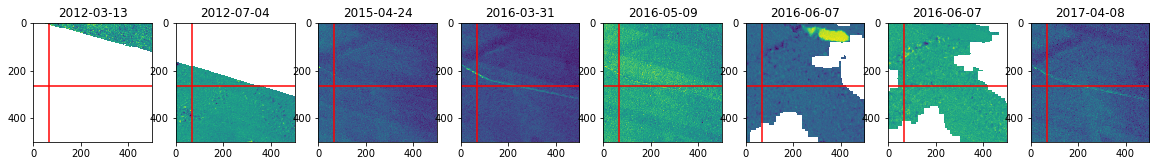

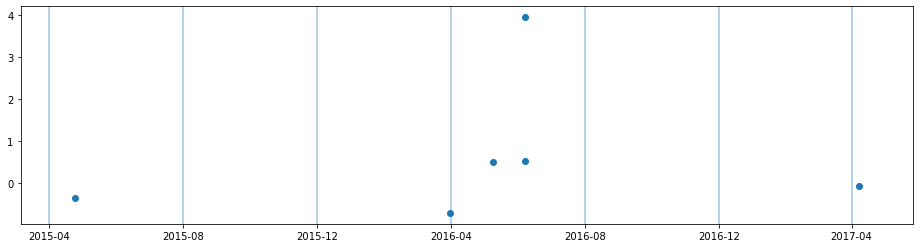

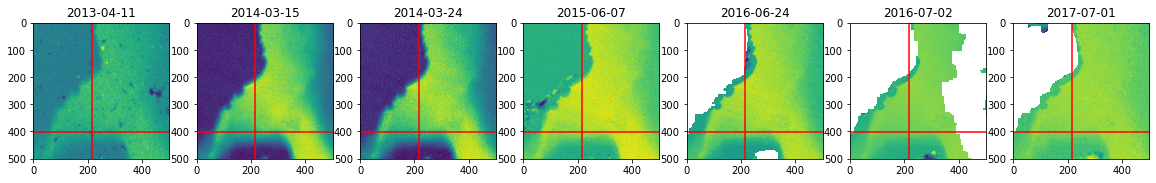

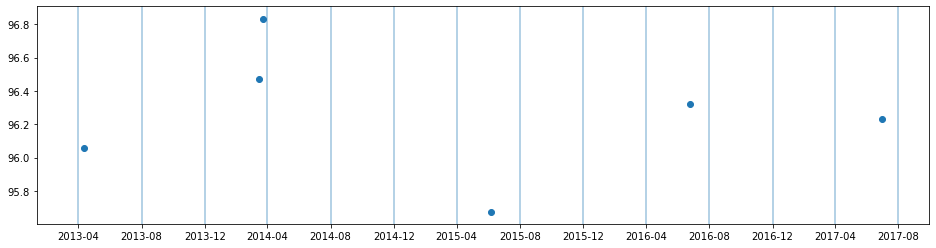

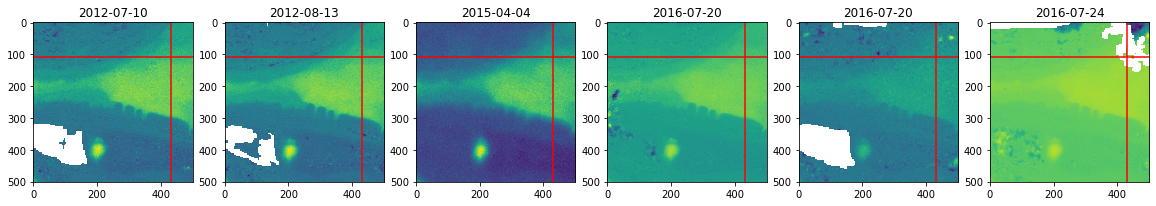

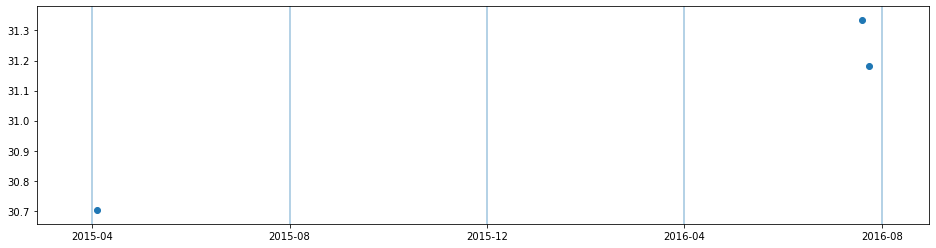

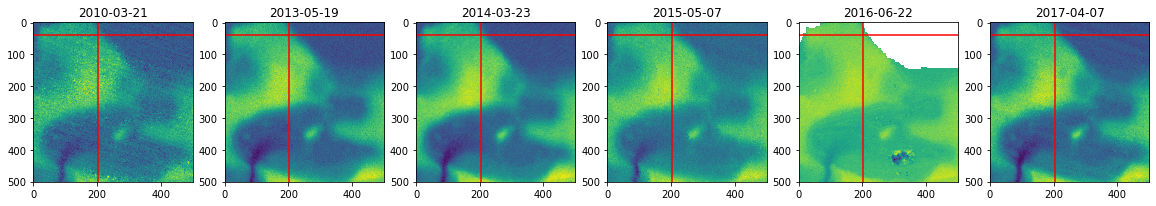

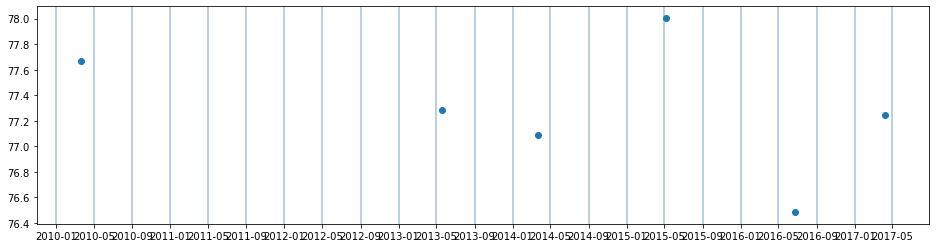

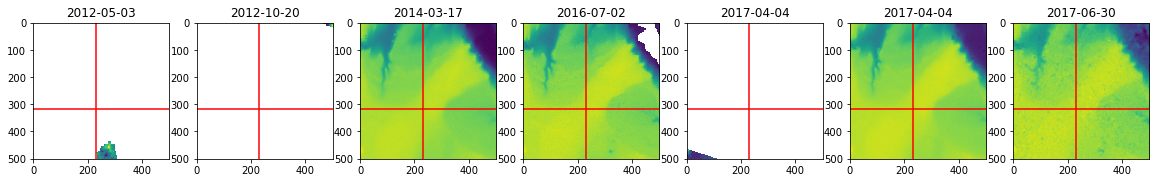

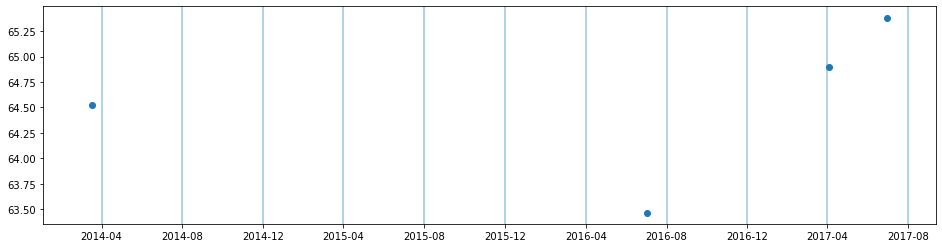

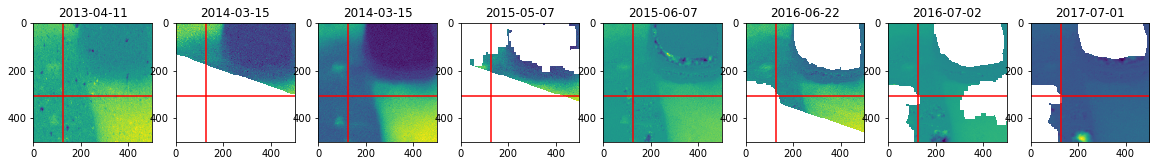

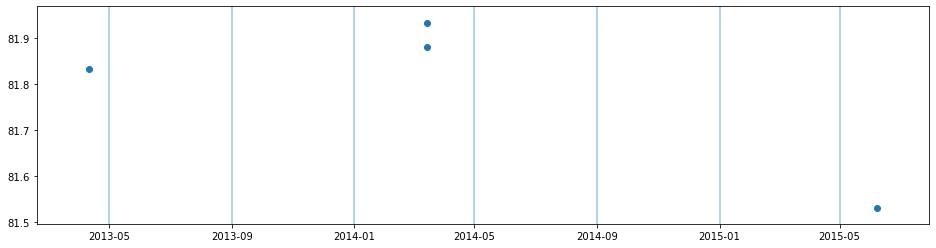

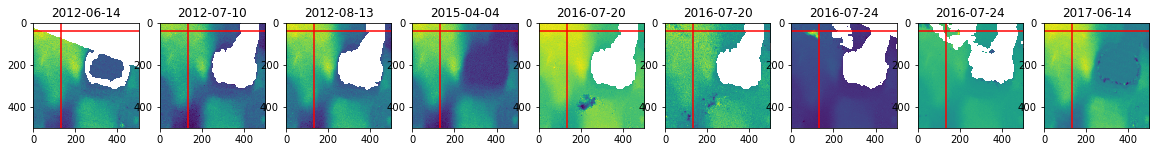

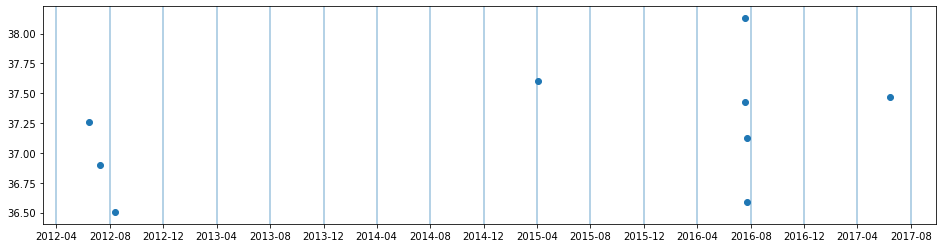

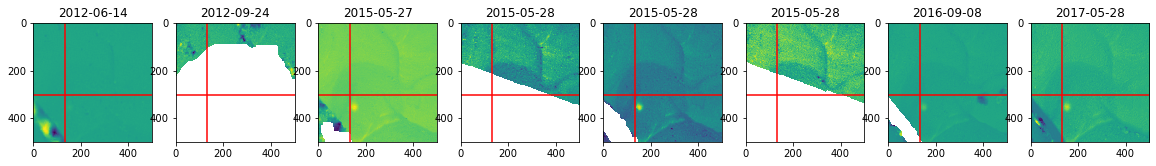

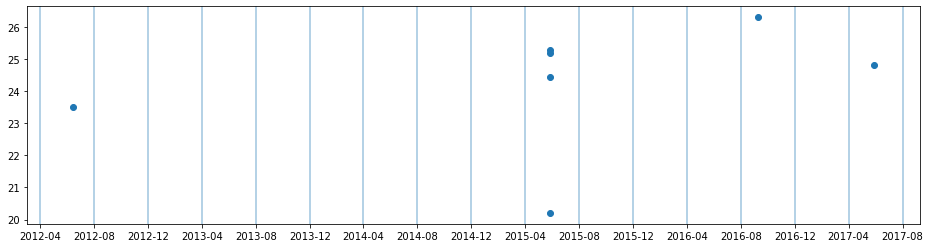

In [20]:
check_grids = grids.sample(10)
for _, grid in check_grids.iterrows():
    x = np.random.randint(0,501)
    y = np.random.randint(0,501)
    plot_pixel(grid,x,y)